In [5]:
class Node:
    def __init__(self,id, minCharAscii = ord('$'), maxCharAscii= ord('~')) -> None:
        """ 
        text[start:end], end is inclusive
        """
        self.start =None
        self.end = None
        self.children = (maxCharAscii+1- minCharAscii) * [None]
        self.minCharAscii = minCharAscii
        self.maxCharAscii = maxCharAscii
        self.suffixLink = None
        self.id =id 
    @property
    def end_value(self):
        return self.end[0] if self.end is not None else None
    def __getCharIndex(self, char):
        return ord(char)-self.minCharAscii
    
    def __setitem__(self, key:str, value):
        key = self.__getCharIndex(key)
        self.children[key] = value
    def __getitem__(self, key:str):
        key = self.__getCharIndex(key)
        return self.children[key]
    def getCopy(self):
        newNode = Node(self.id)
        newNode.start = self.start
        newNode.end = self.end
        newNode.children = self.children.copy()
        newNode.suffixLink = self.suffixLink
        newNode.minCharAscii = self.minCharAscii
        newNode.maxCharAscii = self.maxCharAscii
        
        return newNode
    def __str__(self) -> str:
        return f"start: {self.start}, end: {self.end}, children: {[child.start  for child in self.children if child!=None]}, suffixLink: {self.suffixLink}"

In [6]:
import graphviz

In [23]:
class SuffixTree:
    def __init__(self, minChar = '$', maxChar = '~') -> None:
        self.extension =0
        self.counter =0
        self.maxChar = maxChar
        self.minChar = minChar
        self.root = self.add(0, isRoot=True)
        self.activeNode = self.root
        self.end = [-1]
        self.remStart = 0
        #the char that need to be compare at the phase
        self.activeLength = 0  
        self.lastJ= 0
        self.prevActive =None
        self.text =""
        self.skipLength = 0
        
    def add(self, s, isRoot= False)->Node:
        newNode = Node(self.counter, minCharAscii=ord(self.minChar), maxCharAscii=ord(self.maxChar))
        self.counter+=1
        newNode.start = s # start index of the suffix
        if isRoot:
            newNode.end = [-1]
            newNode.suffixLink = newNode
        else:
            newNode.end = self.end # global end
            newNode.suffixLink = self.root #set suffix link to root for now
        return newNode
    def __getCharIndex(self, char):
        return ord(char)-ord(self.minChar)

    
    def __insert(self,text, p, verbose=False):
        """ 
        assume the active node is the latest and dont need to futher traverse
        need to insert p into the tree
        check if need to branch out
        or just attach to edge to active node
        """
        startChar = text[self.remStart]
        
        activeEdge= None
        #no need to seperate reminder
        if self.activeLength ==0:
            newNode = self.add(p)
            self.activeNode[startChar] = newNode
            if self.activeNode == self.root:
                self.activeLength =1
                
            if verbose: print(f'rule 2b{self.__printSubString(text, self.activeNode)}, new {self.__printSubString(text, newNode)}')

        else:
            activeEdge = self.activeNode[startChar]
            newRemNode = activeEdge.getCopy()
            newRemNode.start = activeEdge.start+self.activeLength
            newStartNode = self.add(activeEdge.start)
            newStartNode.end = [activeEdge.start + self.activeLength-1]
            activeEdge = newStartNode
            self.activeNode[startChar] = activeEdge
            newNode = self.add(p)
            activeNodeStartChar = text[newNode.start]
            remNodeStartChar = text[newRemNode.start]
            activeEdge[activeNodeStartChar] = newNode
            activeEdge[remNodeStartChar] = newRemNode
            if verbose: print(f'rule 2a branching {self.__printSubString(text, activeEdge)}, rem {self.__printSubString(text, newRemNode)} {newRemNode.start, newRemNode.end}, new {self.__printSubString(text, newNode)}')

        
        if self.prevActive is not None and activeEdge is not None:
            self.prevActive.suffixLink = activeEdge
            if verbose: print(f'added suffix link from {self.prevActive.id} to {self.prevActive.suffixLink.id}')

        self.prevActive = activeEdge if activeEdge!= None else self.activeNode
        self.lastJ +=1
        self.activeLength -=1
        self.remStart +=1
        



    
    def __contain(self, text, p, verbose= False):
        """
        e: start of substring from rule 3
        p: current phase- end of substring need to check if p contain
        """
        charTarget = text[p]
        remStartChar = text[self.remStart]
        activeEdge = self.activeNode[remStartChar]
        if activeEdge is None:
            return False
        edgeLength = activeEdge.end_value - activeEdge.start +1
        if self.activeLength ==0:
            return self.activeNode[charTarget] is not None
        else:
            #skip to next node if active length is longer than edge length
            if self.activeLength >= edgeLength:
                if verbose: print(f'changing active node, active length: {self.activeLength}, edge length: {edgeLength}')

                self.activeNode = activeEdge
                self.activeLength -= edgeLength
                self.remStart += edgeLength 
                self.skipLength += edgeLength
                if verbose: print(f'word edge: {self.__printSubString(text,self.activeNode)}new active length: {self.activeLength}, new remStart: {self.remStart}, word checking: {text[self.remStart:p+1]}')

                return self.__contain(text, p, verbose=verbose)
            else:
                #check in between the edge
                if verbose: print(f'checking {text[self.remStart:p+1]} == {text[activeEdge.start:activeEdge.start+self.activeLength+1]}')
                return text[activeEdge.start+self.activeLength] == charTarget
           
    
    def insertAll(self, text:str, verbose=False):
        
        self.lastJ =len(self.text)
        self.text += text
        #phase
        for p in range(len(text)):
            #rule 1
            self.end[0]= self.end[0]+1
            #extension
            self.prevActive = None
            for e in range(self.lastJ, p+1):
                if verbose:
                    print(f"phase: {p}, extension: {e} inserting {text[e:p+1]}, remStart index: {self.remStart}, active length: {self.activeLength}, skip length {self.skipLength}")
                #check if text[e] is in the tree
                if self.__contain(text, p, verbose=verbose):
                    if verbose: print(f'rule 3, {text[e:p+1]} is in the tree')
                    self.activeLength +=1
                    break
                else:
                    self.__insert(text, p, verbose=verbose)
                    
                        


                    
                if verbose: print(f'Current active node {self.activeNode.id}, jumping to suffix link {self.activeNode.suffixLink.id}')
                
                self.activeNode = self.activeNode.suffixLink
                if self.activeNode == self.root:
                    self.activeLength +=self.skipLength
                    self.remStart -= self.skipLength
                    self.skipLength = 0
                else:
                    self.activeLength +=1
                    self.remStart -=1
                    self.skipLength -=1

                
        
                
    def suffixArray(self):
        suffixArray = []
        def suffixArrayAux(node, height=0):
            notLeafNode = False
            for child in node.children:
                if child:
                    notLeafNode = True

                    suffixArrayAux(child, height=height+child.end_value-child.start+1)
            if not notLeafNode:
                suffixArray.append(len(self.text)-height)
        suffixArrayAux(self.root)
        return suffixArray
    def bwt(self):
        suffixArray = self.suffixArray()
        n = len(suffixArray)
        return [ ((i-1)%n)  for i in suffixArray]
                
    def __printSubString(self, text, node:Node):
        return text[node.start:node.end_value+1]
    def printTree(self):
        dot = graphviz.Digraph(comment='Suffix Tree')
    
        def printTreeAux(node):
            for child in node.children:
                if child:
                    label = self.text[child.start:child.end_value+1] + f'(id{child.id}: {child.start},{child.end_value})'
                    dot.node(str(child.id), label)
                    dot.edge(str(node.id), str(child.id))
                    if child.suffixLink!= self.root:
                        dot.edge(str(child.id), str(child.suffixLink.id), style='dashed')
                    printTreeAux(child)

        printTreeAux(self.root)  # Assuming `self.root` is the root of your tree
        return dot
        


In [16]:
def suffix_array_alternative_naive(s):
    return [rank for suffix, rank in sorted((s[i:], i) for i in range(len(s)))]



phase: 0, extension: 0 inserting r, remStart index: 0, active length: 0, skip length 0
rule 2b, new r
Current active node 0, jumping to suffix link 0
phase: 1, extension: 1 inserting a, remStart index: 1, active length: 0, skip length 0
rule 2b, new a
Current active node 0, jumping to suffix link 0
phase: 2, extension: 2 inserting t, remStart index: 2, active length: 0, skip length 0
rule 2b, new t
Current active node 0, jumping to suffix link 0
phase: 3, extension: 3 inserting t, remStart index: 3, active length: 0, skip length 0
rule 3, t is in the tree
phase: 4, extension: 3 inserting ta, remStart index: 3, active length: 1, skip length 0
checking ta == tt
rule 2a branching t, rem ta (3, [4]), new a
Current active node 0, jumping to suffix link 0
phase: 4, extension: 4 inserting a, remStart index: 4, active length: 0, skip length 0
rule 3, a is in the tree
phase: 5, extension: 4 inserting at, remStart index: 4, active length: 1, skip length 0
checking at == at
rule 3, at is in the t

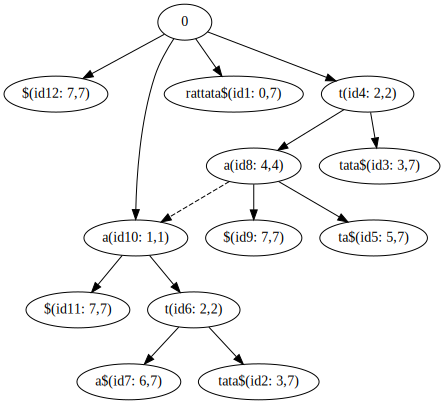

In [27]:
s = "xyzxyaxyz$"
s1 ="mississi$"
s2= "rattata$"
s3 = "AAAABAAAABAAC$"
s4= "xxxyxx$"
s5="abaaba$"
s6="axxxxa$"
s7= "amanaplanacanalpanama$"
s8= "googol$"
s9 = "ababbaba$"
t = SuffixTree()
t.insertAll(s2, verbose=True)
sa=t.suffixArray()
print([s2[i:] for i in sa])
print(suffix_array_alternative_naive(s2))
t.printTree()





'xyzxyaxyz$'

[21, 20, 9, 13, 18, 0, 7, 11, 16, 2, 4, 10, 6, 14, 19, 1, 8, 12, 17, 3, 15, 5]

In [138]:
import random

# Generate a long random string of 10,000 characters between ASCII 37 and 125
random_string = ''.join(chr(random.randint(37, 125)) for _ in range(10000))

# Add the terminator character at the end
random_string += '$'

print(random_string[:100])
with open('random_string.txt', 'w') as f:
    f.write(random_string)

def construct_suffix_array(s):
    return sorted(range(len(s)), key=lambda i: s[i:])

def bwt_from_suffix_array(s, suffix_array):
    return ''.join([s[i-1] if i > 0 else s[-1] for i in suffix_array])

suffix_array = construct_suffix_array(random_string)
bwt = bwt_from_suffix_array(random_string, suffix_array)
with open('randomStringBwt.txt', 'w') as f:
    f.write(bwt)
print(bwt[:100])  # Print the first 100 characters of the BWT


v<yB0SR|(?H}eX*m_>fp-o&6L9Ti/1vZlB}A?%ld}G=@i9SHHDpoP9IS=}k,|M2}C87\w](7Sbj_@zqw:FVNWEO0U3lIxYE?g1a@
o=X|\4`<n]efA<>EfJxtcLYx.8W3>@9[pvPQ&8'4Gerb)\}orTvnfiCR.r%B4v/9?ZYfO}b7N_2/6G@l3&'i&,{9b+>,>,7`?+mv


In [58]:
def countingSort(input:str, minChar = '$', maxChar = '~'):
    minCharIndex = ord(minChar)
    maxCharIndex = ord(maxChar)
    alphabetSize = maxCharIndex-minCharIndex+1
    count = alphabetSize*[0]
    for char in input:
        count[ord(char)-minCharIndex]+=1
    rank = [0]*alphabetSize
    sum =0
    for i in range(alphabetSize):
        sum += count[i]
        if count[i] !=0:
            rank[i] = sum
        
    sortedInput = len(input)*[None]
    for char in input:
        index = ord(char)-minCharIndex
        rank[index]-=1
        sortedInput[rank[index]] = char
        
    return sortedInput, rank, count

In [61]:
def occurenceCountTable(input:str, minChar = '$', maxChar = '~'):
    alphabetSize = ord(maxChar)-ord(minChar)+1
    occurenceCount = alphabetSize*[0]
    occurenceCountTable =[]
    for char in input:
        index = ord(char)-ord(minChar)
        occurenceCount[index]+=1
        occurenceCountTable.append(occurenceCount.copy())
    return occurenceCountTable

In [66]:
def exactPatternMatching(bwt:str, pattern:str):
    #convert to sorted suffix array by reverse the index of bwt
    sortedBwt, rank, count = countingSort(bwt)
    occurenceCount = occurenceCountTable(bwt)

    #pattern matching
    sp = 0
    ep = len(bwt)-1
    while sp <= ep:
        if pattern:
            char = pattern[-1]
            pattern = pattern[:-1]
            index = ord(char)-ord('$')
            sp = rank[index] + occurenceCount[sp][index]
            ep = rank[index] + occurenceCount[ep+1][index]-1
        else:
            return sp, ep




In [67]:
bwt = 'owolllmoooo$w'
patternMatching(bwt, 'anana')


['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 1, '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 1, '', '', '', '', '', '', '', 1, '', '', '', '', '', '', '']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 

In [64]:
def generate_OCC(bwt):
    # Initialize the OCC table
    occ = [{} for _ in range(len(bwt))]
    
    # Populate the first row
    for char in set(bwt):
        occ[0][char] = 1 if bwt[0] == char else 0
        
    # Populate the rest of the table
    for i in range(1, len(bwt)):
        for char in set(bwt):
            occ[i][char] = occ[i-1][char] + (1 if bwt[i] == char else 0)
    
    return occ

bwt = "owolllmoooo$w"
occ_table = generate_OCC(bwt)
for row in occ_table:
    print(row)


{'m': 0, '$': 0, 'o': 1, 'w': 0, 'l': 0}
{'m': 0, '$': 0, 'o': 1, 'w': 1, 'l': 0}
{'m': 0, '$': 0, 'o': 2, 'w': 1, 'l': 0}
{'m': 0, '$': 0, 'o': 2, 'w': 1, 'l': 1}
{'m': 0, '$': 0, 'o': 2, 'w': 1, 'l': 2}
{'m': 0, '$': 0, 'o': 2, 'w': 1, 'l': 3}
{'m': 1, '$': 0, 'o': 2, 'w': 1, 'l': 3}
{'m': 1, '$': 0, 'o': 3, 'w': 1, 'l': 3}
{'m': 1, '$': 0, 'o': 4, 'w': 1, 'l': 3}
{'m': 1, '$': 0, 'o': 5, 'w': 1, 'l': 3}
{'m': 1, '$': 0, 'o': 6, 'w': 1, 'l': 3}
{'m': 1, '$': 1, 'o': 6, 'w': 1, 'l': 3}
{'m': 1, '$': 1, 'o': 6, 'w': 2, 'l': 3}
